# Pre-requisites (optional but recommended)
Only do the first step if you have never created a virtual environment for this repository. Otherwise, make sure that the Python Kernel that you selected is from your venv/ folder.

In [2]:
! source ../venv/bin/activate

In [49]:
! python3 -V
! which python3

Python 3.13.11
/Users/jcheng/Documents/ljcheng/ml/learning/repos/rag-langchain-agent/venv/bin/python3


# Topics Covered:
- LangChain LLM Basics
- LLM Invocation
- LLM with Tools
- Structured Output from LLM
- Basic LangGraph Chatbot
- Adding Memory to the Chatbot
- LangGraph Agent with Tools
- LangGraph RAG Agent

### Part 1: Environment and Packages

In [1]:
! pip3 install -q --upgrade pip
! pip3 install -qU langchain langchain-openai langchain-community langchain-core python-dotenv python-multipart

In [34]:
import os
from dotenv import load_dotenv

# Load all environment variables from .env file
load_dotenv()

# Access the environment variables
langchain_tracing_v2 = os.getenv('LANGCHAIN_TRACING_V2')
langchain_endpoint = os.getenv('LANGCHAIN_ENDPOINT')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')

## LLM
openai_api_key = os.getenv('OPENAI_API_KEY')

if(not os.getenv('LANGCHAIN_API_KEY')):
  raise KeyError("set LANGCHAIN_API_KEY")
if(not os.getenv('OPENAI_API_KEY')):
  raise KeyError("set OPENAI_API_KEY")
if(not os.getenv("TAVILY_API_KEY")):
  raise RuntimeError("Set TAVILY_API_KEY")

   

In [3]:
from langchain_openai import ChatOpenAI
# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

In [4]:
from langchain_core.messages import HumanMessage, SystemMessage
# Using messages for more control
messages = [
  SystemMessage(content="You are a helpful AI assistant that explains complex topics simply."),
  HumanMessage(content="Explain machine learning in 2 sentences.")
]

response = llm.invoke(messages)
response

AIMessage(content='Machine learning is a type of artificial intelligence where computers learn patterns from data to make decisions or predictions without being explicitly programmed for each task. It enables systems to improve their performance over time by automatically analyzing and adapting based on new information.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 31, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D6haXvyom1KalZ8PBUOwqdRcBgxNJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c396b-ce77-7551-8f56-e14c39663340-0', tool_calls=[], invalid_tool_calls=[], usage_metadata

# LLM with Tools

In [5]:
# Free to use, refer other infor here: https://docs.langchain.com/oss/python/integrations/tools/google_serper

In [105]:
! pip3 freeze > ../requirements.txt

In [6]:
from langchain_core.tools import tool
from langchain_community.utilities import GoogleSerperAPIWrapper
## https://docs.langchain.com/oss/python/integrations/tools/google_serper

search = GoogleSerperAPIWrapper() # Initialize an instance before the decorator tool under internet_serper_search()
# search = GoogleSerperAPIWrapper(type="news")

In [7]:
@tool
def calculator(expression: str) -> str:
  """Calculate mathematical expressions. Use this for any math calculations."""
  try:
    result = eval(expression)
    return f"The result of {expression} is {result}"
  except Exception as e:
    return f"Error calculating {expression}: {str(e)}"

@tool
def internet_serper_search(query: str) -> str:
  """Useful for when you need to ask with search."""
  return search.run(query)

# Bind tools to the LLM
llm_with_tools = llm.bind_tools([calculator, internet_serper_search])

# Test the calculator tool
print("Testing Calculator Tool:")
response = llm_with_tools.invoke("What's 25 * 4 + 17?")
print(f"Response: {response.content}")

Testing Calculator Tool:
Response: 


LLM decided to use the calculator tool instead of the search_tool

In [8]:
response
response.tool_calls

[{'name': 'calculator',
  'args': {'expression': '25 * 4 + 17'},
  'id': 'call_Ng0dgaUr9ujS4xah82qyskL8',
  'type': 'tool_call'}]

In [9]:
# Map tool names to tool objects for dynamic execution
tool_map = {
  'calculator': calculator,
  'internet_serper_search': internet_serper_search,
}

def handle_tool_calls(response, tool_map):
  """Executes all tool calls in the LLM response using the tool_map."""
  if not getattr(response, 'tool_calls', None):
    return

  print(f"Tool calls requested: {len(response.tool_calls)}")
  for tool_call in response.tool_calls:
    tool_name = tool_call['name']
    args = tool_call['args']
    print(f"Tool: {tool_name}")
    print(f"Args: {args}")

    tool = tool_map.get(tool_name)
    if tool:
      result = tool.invoke(args)
      # Print first 200 chars for long responses (e.g., search)
      preview = result[:200] + "..." if isinstance(result, str) and len(result) > 200 else result
      print(f"Tool result: {preview}")

In [10]:

def test_llm_tool(query):
  print(f"Query: {query}")
  response = llm_with_tools.invoke(query)
  print(f"Response: {getattr(response, 'content', response)}")
  handle_tool_calls(response, tool_map)
  print("\n")

test_llm_tool("What's 25 * 4 + 17?")
test_llm_tool("Search for recent news about artificial intelligence")

Query: What's 25 * 4 + 17?
Response: 
Tool calls requested: 1
Tool: calculator
Args: {'expression': '25 * 4 + 17'}
Tool result: The result of 25 * 4 + 17 is 117


Query: Search for recent news about artificial intelligence
Response: 
Tool calls requested: 1
Tool: internet_serper_search
Args: {'query': 'recent news about artificial intelligence 2024'}
Tool result: AI 2024: 1. Most notable AI-related cybersecurity story 2. Most impactful AI-related regulation 3. Most significant AI hardware development. Artificial Intelligence. April 11, 2024. UK and Canada sign...




# STRUCTURED OUTPUT FROM LLM

In [14]:
from pydantic import BaseModel, Field
from typing import List, Optional

class PersonInfo(BaseModel):
  """Information about a person"""
  name: str = Field(description="Full name of the person")
  age: Optional[int] = Field(description="Age of the person")
  occupation: str = Field(description="Person's job or profession")
  skills: List[str] = Field(description="List of skills or expertise")

structured_llm = llm.with_structured_output(PersonInfo)

# Test with person information
print("Testing Structured Output - Person Info:")
person_prompt = """
Extract information about this person:
"John Smith is a 35-year-old software engineer who works at Google.
He specializes in machine learning, Python programming, and cloud architecture.
John has been working in tech for over 10 years and is passionate about AI research."
"""

person_result = structured_llm.invoke(person_prompt)
print(f"Name: {person_result.name}")
print(f"Age: {person_result.age}")
print(f"Occupation: {person_result.occupation}")
print(f"Skills: {', '.join(person_result.skills)}")

Testing Structured Output - Person Info:
Name: John Smith
Age: 35
Occupation: Software Engineer
Skills: Machine Learning, Python Programming, Cloud Architecture


# Part 2: Basic LangGraph Chatbot

In [15]:
!pip3 install -qU langgraph

# LangGragh State

In [16]:
from typing import Annotated, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

In [17]:
class State(TypedDict):
  """State for our chatbot - this holds the conversation history"""
  # The add_messages function handles appending new messages to the conversation
  messages: Annotated[list[BaseMessage], add_messages]

# Initialize the LLM
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)

# CREATING THE CHATBOT NODE

In [18]:
def chatbot_node(state: State) -> State:
  """
  The main chatbot node that processes messages and generates responses
  """
  print(f"Processing {len(state['messages'])} messages")

  # Get the response from the LLM
  response = llm.invoke(state["messages"])

  # Return the updated state with the new response
  return {"messages": [response]}

print("Chatbot node function created")

Chatbot node function created


In [19]:
from langgraph.graph import StateGraph, START, END
graph_builder = StateGraph(State)

# Add the chatbot node to the graph
graph_builder.add_node("chatbot", chatbot_node)

# Define the flow: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()

print("Graph structure created")
print("Graph compiled successfully")

Graph structure created
Graph compiled successfully


In [34]:
!pip3 install grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [grandalf]━━ 1/2 [grandalf]


---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



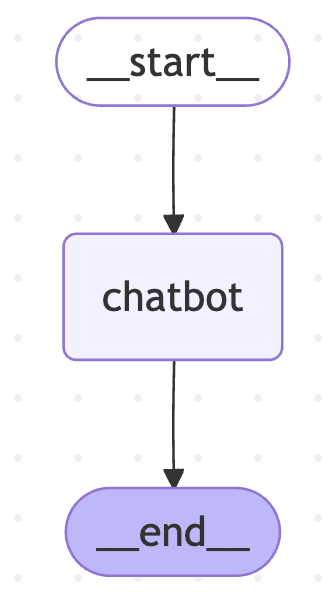

In [54]:
# graph.get_graph().print_ascii()
print(graph.get_graph(xray=True).draw_mermaid())
from IPython.display import Image, display
display(Image("../assets/basic-graph.png", width=150))

## TESTING THE CHATBOT WITHOUT MEMORY

In [ ]:
def test_chatbot(message: str):
  """Helper function to test our chatbot"""
  print(f"\n🤖 User: {message}")

  # Create the initial state with the user message
  initial_state = {"messages": [HumanMessage(content = message)]}

  # Run the graph
  result = graph.invoke(initial_state)

  print(f"🤖 in the middle: {result}")
  # Get the AI response
  ai_response = result["messages"][-1].content
  print(f"🤖 Assistant: {ai_response}")

  return result

# Test with simple messages
test_cases = [
  "Hello! My Name Johnny",
  "Do you remeber my name?"
]

## Currently, the AI doesn't have memory, so he won't be able to remember any previous messages
for test_message in test_cases:
  test_chatbot(test_message)


🤖 User: Hello! My Name Johnny
Processing 1 messages
🤖 in the middle: {'messages': [HumanMessage(content='Hello! My Name Johnny', additional_kwargs={}, response_metadata={}, id='c7793c68-b215-4268-8f1d-d7c85710e3a9'), AIMessage(content='Hello Johnny! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 12, 'total_tokens': 22, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_75546bd1a7', 'id': 'chatcmpl-D6IfB9PstNupxJgbwSn2TPM2ROO4v', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--019c33b5-d589-7481-b88a-dd5b25603147-0', tool_calls=[], invalid_tool_calls=[], usage_metadata={'input_tokens': 12, 'output_tokens': 10, 

## ADDING MEMORY TO THE CHATBOT

In [20]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()

In [21]:
# Compile the graph with memory
graph_with_memory = graph_builder.compile(checkpointer = memory)

print("Memory added to chatbot")

def chat_with_memory(message: str, thread_id: str):
  """Chat function with memory"""
  print(f"\n👤 User: {message}")

  # Configuration for the thread
  config = {"configurable": {"thread_id": thread_id}}

  # Add the user message to the conversation
  initial_state = {"messages": [HumanMessage(content=message)]}

  # Run the graph with memory
  result = graph_with_memory.invoke(initial_state, config)

  # Get the AI response
  ai_response = result["messages"][-1].content
  print(f"🤖 Assistant: {ai_response}")


# Test conversation with memory
print("\nTesting Conversation with Memory:")

# Start a conversation
chat_with_memory("Hi, my name is Johnny", thread_id="thread-1")
chat_with_memory("What's my name?", thread_id="thread-1")

Memory added to chatbot

Testing Conversation with Memory:

👤 User: Hi, my name is Johnny
Processing 1 messages
🤖 Assistant: Hello Johnny! How can I assist you today?

👤 User: What's my name?
Processing 3 messages
🤖 Assistant: Your name is Johnny. How can I help you further?


# Part 3: Langgraph Agent with Tools

In [22]:
# Define a state
class AgentState(TypedDict):
  """State for our two-node agent"""
  messages: Annotated[list[BaseMessage], add_messages]

# Initialize LLM with tools
llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)
# llm_with_tools = llm.bind_tools(tools)
llm_with_tools = llm.bind_tools([calculator, internet_serper_search])

### Creating a Chatbot Node

In [23]:
def chatbot_node(state: AgentState) -> AgentState:
  """
  The chatbot node that decides whether to use tools or provide direct responses
  """
  messages = state["messages"]

  # Add system prompt
  system_message = """You are a helpful AI assistant. You have access to web search and calculator tools.

  Use the web_search tool when:
  - Asked about current events, news, or recent information
  - Need to find specific facts or data
  - Asked about real-time information (weather, stock prices, etc.)

  Use the calculator tool when:
  - Asked to perform mathematical calculations
  - Need to solve math problems

  For general knowledge questions that don't require real-time data, answer directly.
  Be helpful and conversational in your responses."""

  # Prepare messages with system prompt
  all_messages = [{
    "role": "system",
    "content": system_message
  }] + messages

  # Get response from LLM
  response = llm_with_tools.invoke(all_messages)

  return {"messages": [response]}

print("Chatbot node created")

Chatbot node created


## Creating tool node and routing logic

In [24]:
from langgraph.prebuilt import ToolNode
from typing import Literal

llm_with_tools

RunnableBinding(bound=ChatOpenAI(profile={'max_input_tokens': 1047576, 'max_output_tokens': 32768, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x113858690>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x113858410>, root_client=<openai.OpenAI object at 0x113858050>, root_async_client=<openai.AsyncOpenAI object at 0x1138587d0>, model_name='gpt-4.1-mini', temperature=0.7, model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True), kwargs={'tools': [{'type': 'function', 'function': {'name': 'calculator', 'description': 'Calculate mathematical expressions. Use this for

In [32]:
tool_node = ToolNode(tools=[calculator, internet_serper_search])

# =========================================
print("Tool Node get created")

def should_continue(state: AgentState) -> Literal["tools", "end"]:
  """
  Determine whether to continue to tools or end the conversation
  """
  messages = state["messages"]
  last_message = messages[-1]
  print(f"last_message - {last_message}")

  # If the last message has tool calls, go to tools
  if(hasattr(last_message, 'tool_calls') and last_message.tool_calls):
    return "tools"
  # Otherwise, end the conversation
  else:
    return "end"

print("Routing logic created")

Tool Node get created
Routing logic created


## Building Graph

In [31]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

Graph compiled with memory

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	chatbot(chatbot)
	tools(tools)
	__end__([<p>__end__</p>]):::last
	__start__ --> chatbot;
	chatbot -. &nbsp;end&nbsp; .-> __end__;
	chatbot -.-> tools;
	tools --> chatbot;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



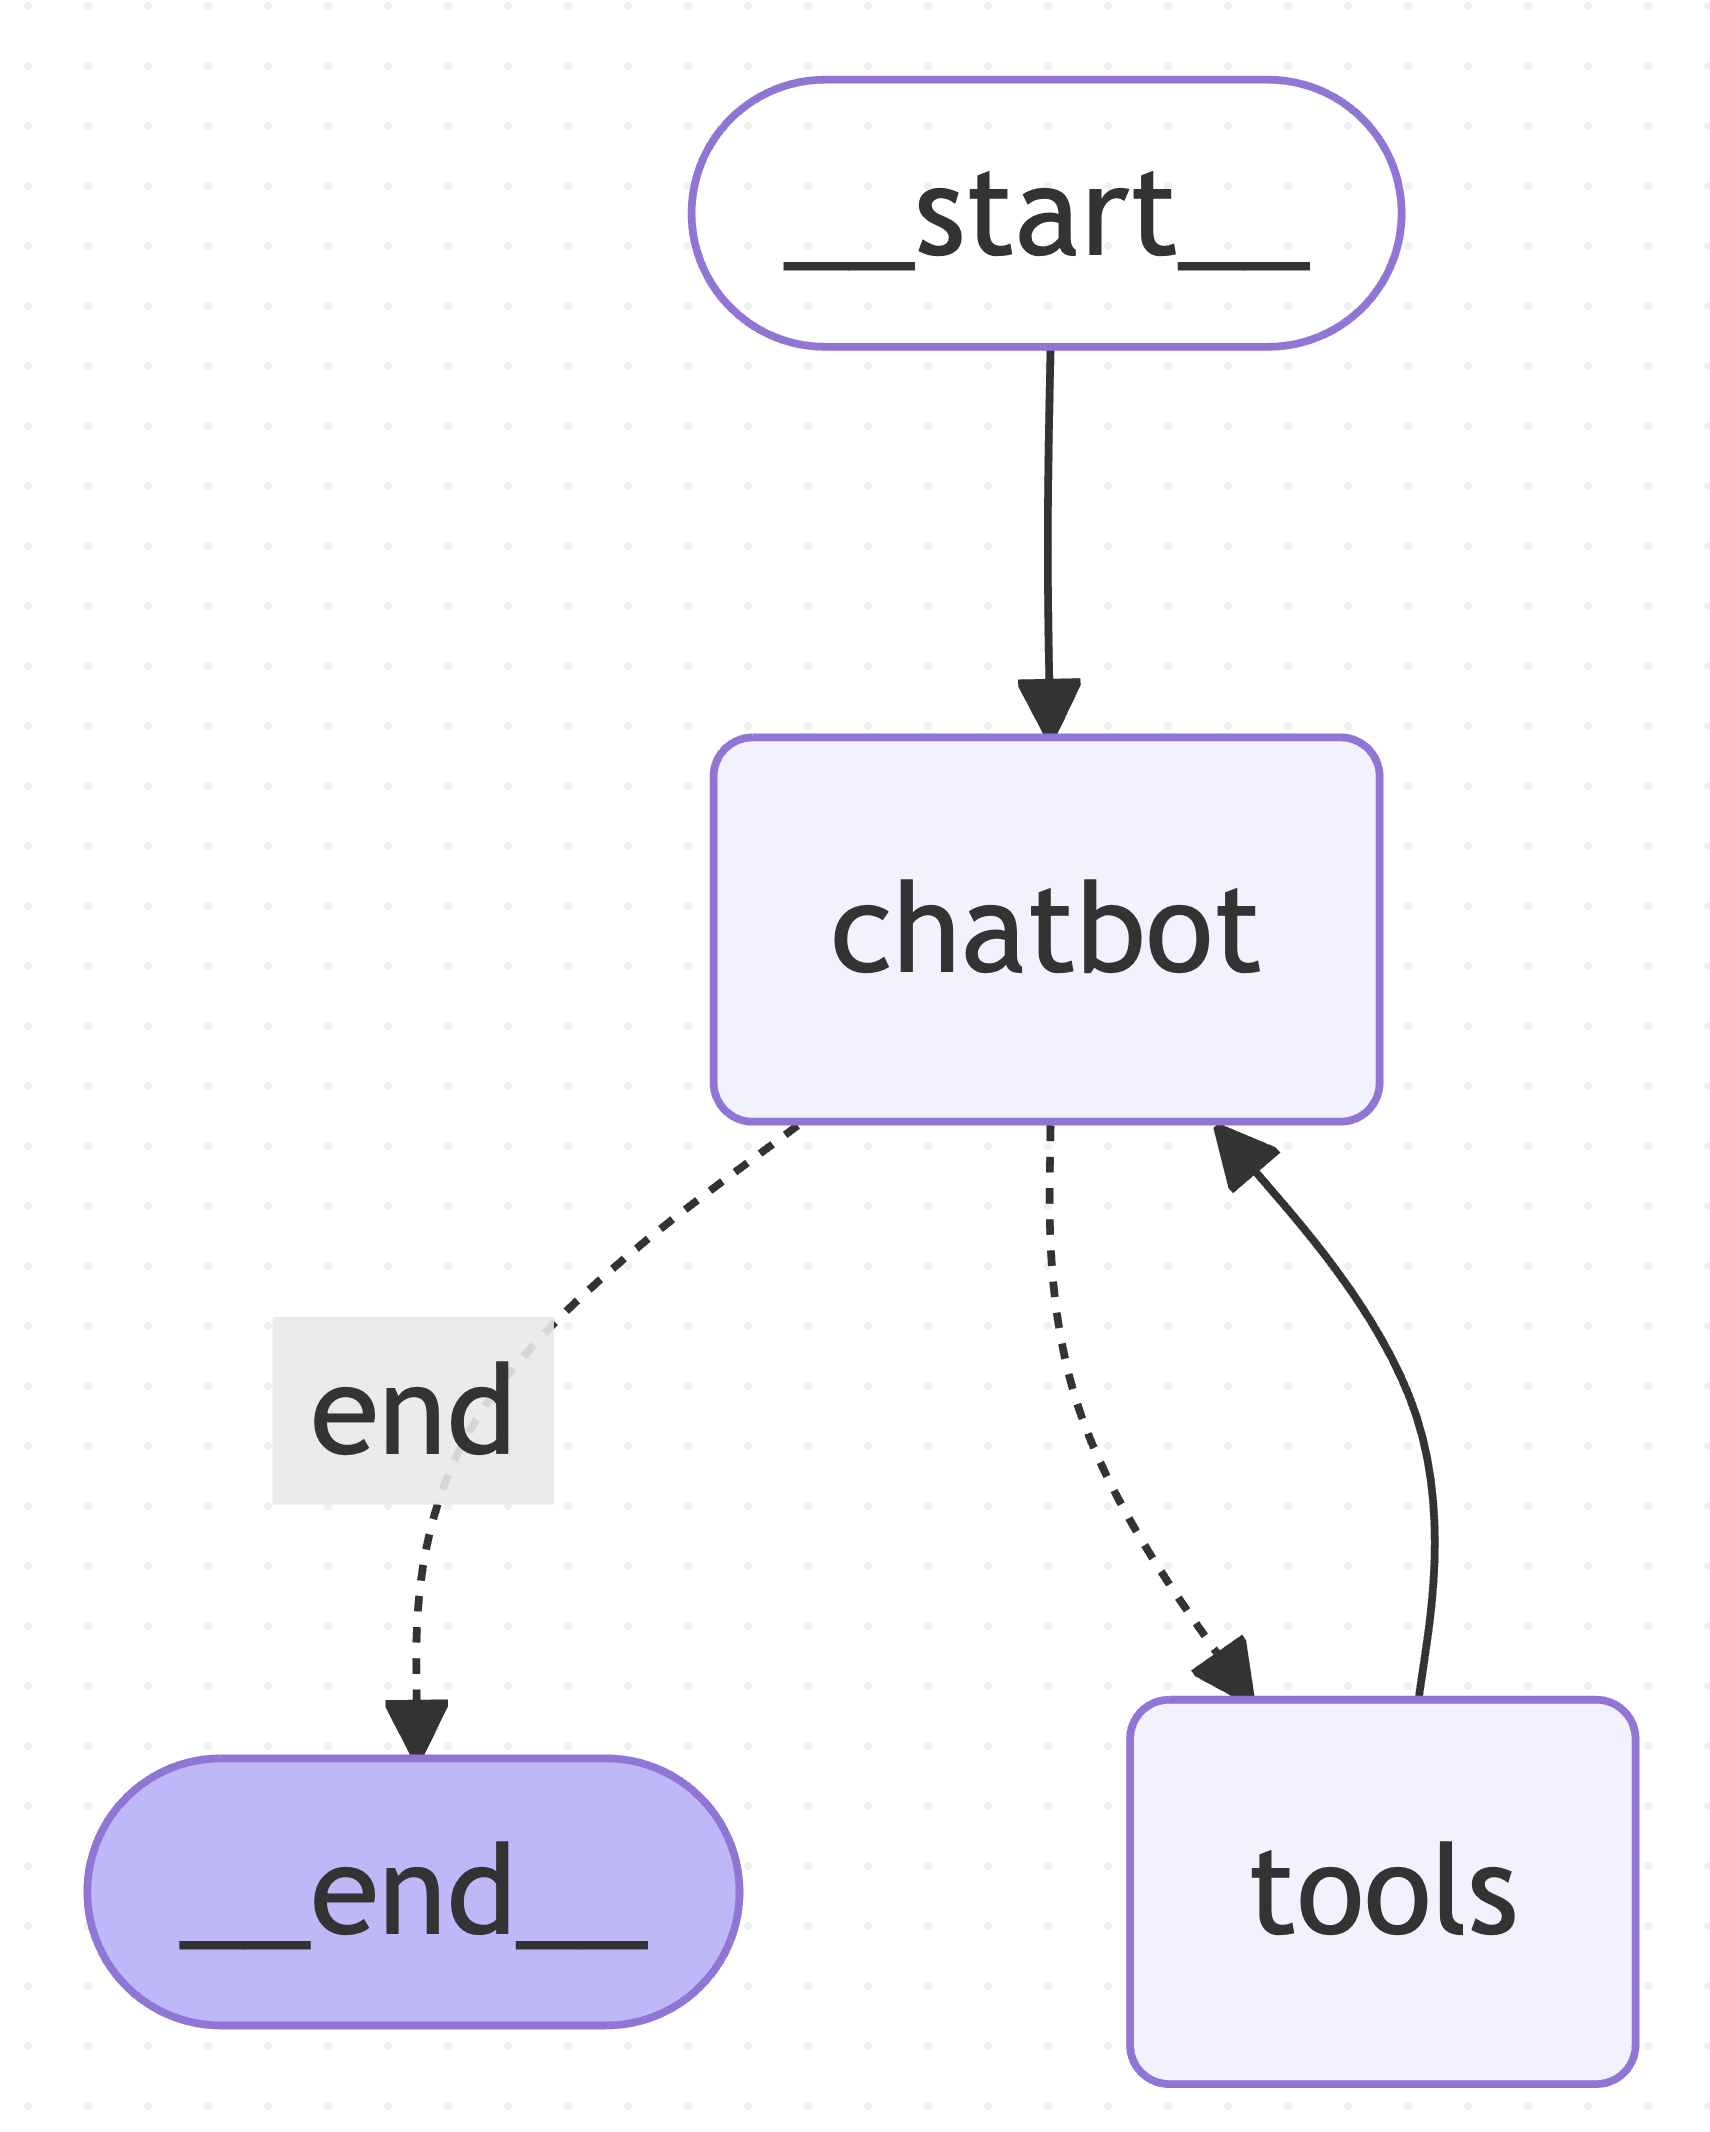

In [50]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("chatbot", chatbot_node)
workflow.add_node("tools", tool_node)

# Set entry point
workflow.add_edge(START, "chatbot")

# Add conditional edges
workflow.add_conditional_edges(
  "chatbot",
  should_continue,
  {
    "tools": "tools",
    "end": END,
  },
)

# After using tools, go back to chatbot
workflow.add_edge("tools", "chatbot")

# Compile the graph
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("Graph compiled with memory\n")

# ============================================================================
# VISUALIZE THE GRAPH
# ============================================================================
print(app.get_graph(xray=True).draw_mermaid())
from IPython.display import Image, display
display(Image("../assets/conditional-graph.png", width=300))

### Testing the agent

In [55]:
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
def chat_with_agent(message: str, thread_id: str):
  """Chat with the two-node agent"""
  print(f"\n👤 User: {message}")

  config = {"configurable": {"thread_id": thread_id}}

  # Stream the response to see the process
  messages_to_process = {"messages": [HumanMessage(content=message)]}

  for event in app.stream(messages_to_process, config):
    for value in event.values():
      if("messages" in value):
        last_message = value["messages"][-1]
        if(hasattr(last_message, 'content') and last_message.content):
          if(isinstance(last_message, AIMessage)):
            print(f"🤖 Assistant: {last_message.content}")
          elif(isinstance(last_message, ToolMessage)):
            print(f"🔧 Tool Result: {last_message.content[:100]}...")

while True:
  user_input = input("User: ")
  if(user_input.lower() == "exit"):
    break
  chat_with_agent(user_input, thread_id="thread-2")

# Statements/Questions
# I am Johnny
# Do you remember my name
# What's 15% of 240?
# What's the latest news about artificial intelligence?
# Follow-up: Can you tell me more about that?


👤 User: My name is Johnny
🤖 Assistant: Hi Johnny! How can I assist you today?

👤 User: what is square root of 169
🔧 Tool Result: Error calculating sqrt(169): name 'sqrt' is not defined...
🔧 Tool Result: Error calculating 169^(1/2): unsupported operand type(s) for ^: 'int' and 'float'...
🔧 Tool Result: The result of 169**0.5 is 13.0...
🤖 Assistant: The square root of 169 is 13.0.

👤 User: 
🤖 Assistant: Is there anything else you would like to know or need help with?


## Part 4: Advanced Langgraph Agent

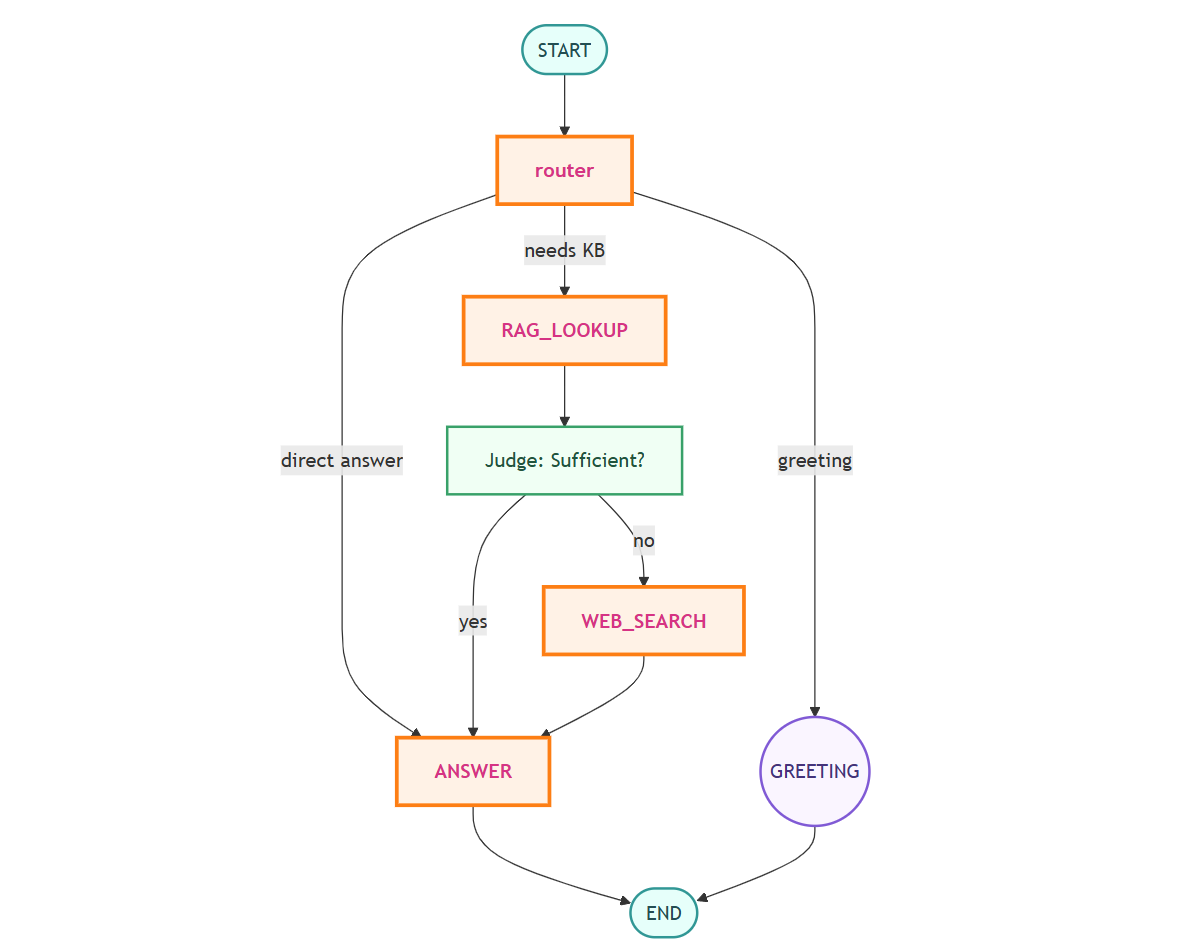

In [11]:
from IPython.display import Image, display
display(Image("../assets/advanced-rag-agent-graph.png", width=500))

In [12]:
!pip -q install docx2txt pypdf unstructured certifi

In [22]:
# import os
# import certifi

# # Set up SSL certificates BEFORE importing anything that needs HTTPS
# os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
# os.environ['SSL_CERT_FILE'] = certifi.where()

!pip3 install -qU langgraph langchain langchain-openai langchain-core langchain-community langchain-chroma chromadb

In [73]:
# !pip3 install -qU "langchain-chroma>=0.1.2"
# !pip3 install -qU langchain-chroma
# !pip3 uninstall -y langchain-chroma

# from langchain_community.vectorstores  import Chroma

# # from langchain_chroma import Chroma
# import chromadb, uuid

Found existing installation: langchain-chroma 1.1.0
Uninstalling langchain-chroma-1.1.0:
  Successfully uninstalled langchain-chroma-1.1.0


In [23]:
"""
Build & persist a Chroma vector index from PDF / DOCX / MD / TXT files.
Run this once; the agent will query the saved index at runtime.
"""
# ── Imports ───────────────────────────────────────────────────────────
from pathlib import Path
from typing   import List
from langchain_community.document_loaders import (
  PyPDFLoader, Docx2txtLoader, TextLoader, UnstructuredMarkdownLoader
)
from langchain_community.document_loaders.directory import DirectoryLoader
from langchain_text_splitters          import RecursiveCharacterTextSplitter
from langchain_openai                  import OpenAIEmbeddings
from langchain_core.documents          import Document

In [24]:
def load_documents(folder_path: str) -> List[Document]:
  documents = []
  for filename in os.listdir(folder_path):
    # print("filename: ", filename)
    file_path = os.path.join(folder_path, filename)
    if(filename.endswith('.pdf')):
      loader = PyPDFLoader(file_path)
    elif(filename.endswith('.docx')):
      loader = Docx2txtLoader(file_path)
    else:
      print(f"Unsupported file type: {filename}")
      continue
    documents.extend(loader.load())
  return documents

folder_path = "../docs"
documents = load_documents(folder_path)
print(f"Loaded {len(documents)} documents from the folder.")

Loaded 19 documents from the folder.


In [25]:
documents[1]

Document(metadata={'source': '../docs/GreenGrowInnovations_CompanyHistory.docx'}, page_content="GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.\n\n\n\nIn its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.\n\n\n\nBy 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors to analyze 

In [26]:
text_splitter = RecursiveCharacterTextSplitter(
  chunk_size=1000,
  chunk_overlap=200,
  length_function=len
)

chunks = text_splitter.split_documents(documents)
print(f"Split the documents into {len(chunks)} chunks.")

Split the documents into 57 chunks.


In [31]:
from langchain_community.vectorstores  import Chroma
import chromadb, logging, os

# ── Config ────────────────────────────────────────────────────────────
SOURCE_DIR   = Path("docs")               # put your files here
INDEX_DIR    = "./chroma_db"
COLLECTION   = "langchain_collection"
EMBED_MODEL  = "text-embedding-3-small"

print("REQUESTS_CA_BUNDLE:", os.getenv("REQUESTS_CA_BUNDLE"))
print("SSL_CERT_FILE:", os.getenv("SSL_CERT_FILE"))
print("ANONYMIZED_TELEMETRY:", os.getenv("ANONYMIZED_TELEMETRY"))

embeddings = OpenAIEmbeddings(model=EMBED_MODEL)
#############################################################################

vector_db   = Chroma.from_documents(
  documents         = chunks,
  embedding         = embeddings,
  persist_directory = INDEX_DIR,
  collection_name   = COLLECTION,
)
vector_db.persist()

#############################################################################

# chroma = chromadb.PersistentClient(path="./chroma_db")
# collection = chroma.get_or_create_collection(COLLECTION)
# import uuid
# doc_id = str(uuid.uuid4())
# collection.add(documents=documents, ids=[doc_id])

# logging.info(f"received a new text/document with generated UUID: {doc_id}")

REQUESTS_CA_BUNDLE: None
SSL_CERT_FILE: None
ANONYMIZED_TELEMETRY: false


In [30]:

retriever = vector_db.as_retriever(search_kwargs={"k": 2})
retriever_results = retriever.invoke("When was GreenGrow Innovations founded?")
retriever_results

[Document(metadata={'source': '../docs/GreenGrowInnovations_CompanyHistory.docx'}, page_content='GreenGrow Innovations was founded in 2010 by Sarah Chen and Michael Rodriguez, two agricultural engineers with a passion for sustainable farming. The company started in a small garage in Portland, Oregon, with a simple mission: to make farming more environmentally friendly and efficient.\n\n\n\nIn its early days, GreenGrow focused on developing smart irrigation systems that could significantly reduce water usage in agriculture. Their first product, the WaterWise Sensor, was launched in 2012 and quickly gained popularity among local farmers. This success allowed the company to expand its research and development efforts.\n\n\n\nBy 2015, GreenGrow had outgrown its garage origins and moved into a proper office and research facility in the outskirts of Portland. This move coincided with the development of their second major product, the SoilHealth Monitor, which used advanced sensors to analyze

In [32]:
!pip3 install -qU langchain-tavily

In [ ]:
from langchain_tavily import TavilySearch

tavily = TavilySearch(max_results=3, topic="general")

@tool
def web_search_tool(query: str) -> str:
  """Up-to-date web info via Tavily"""
  try:
    result = tavily.invoke({"query": query})

    # Extract and format the results from Tavily response
    if isinstance(result, dict) and 'results' in result:
      formatted_results = []
      for item in result['results']:
        title = item.get('title', 'No title')
        content = item.get('content', 'No content')
        url = item.get('url', '')
        formatted_results.append(f"Title: {title}\nContent: {content}\nURL: {url}")

      return "\n\n".join(formatted_results) if formatted_results else "No results found"
    else:
      return str(result)
  except Exception as e:
    return f"WEB_ERROR::{e}"

@tool
def rag_search_tool(query: str) -> str:
  """Top-3 chunks from KB (empty string if none)"""
  try:
    docs = retriever.invoke(query, k=3)
    return "\n\n".join(d.page_content for d in docs) if docs else ""
  except Exception as e:
    return f"RAG_ERROR::{e}"

ValidationError: 1 validation error for TavilySearchAPIWrapper
  Value error, Did not find tavily_api_key, please add an environment variable `TAVILY_API_KEY` which contains it, or pass `tavily_api_key` as a named parameter. [type=value_error, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/value_error